In [58]:
import os
import qm
from entropylab import *
import numpy as np
import matplotlib.pyplot as plt

In [125]:
%config Completer.use_jedi = False



<div align="center"> <font size="+5"><u>Entropy: A lab workflow manager<\u></font></div>


Entropy is a tool for managing your quantum workflow. It allows you to build complex experiments, coordinating lab instruments and arbitrary computational steps. 
This notebook introduces the basic concepts needed to start working with Entropy.

# The Experiment and Graph

An experiment is a set of steps. 
These steps can depend on each other.
Each step is a node.

Each step needs must be traceable: we want to save data, we want to easily access data. 
A graph is a good representation.

# The Entropy Environment

An experiment has dependencies. 
The definition of a dependency is very broad: from an instrumnet, to software components, to calculations. 
These need to be shared between steps within the experiments and between different executions of experiments. 

To solve this we have the concept of a run environmet. 

It contains resources and is automatically visible to Nodes in an experiment graph.

# Results in Entropy

The results DB is an automatic and easy way to save and access results.

Entropy was designed to support different implementations of a DB. You can use a SQL DB, but don't have to. 
We will deploy several back ends, including for example to file based solutions such as HDF5

To support traceability, Entropy does not save only results, but metadata, debugging data etc. 

# Your first node

The PyNode is the basic element in an Entropy grpah. It runs arbitrary python code.
The function called by the node must return a dictionary with result names as keys. 



In [46]:
def my_func():
    return {'res':1}

node1 = PyNode("first_node", my_func,output_vars={'res'})
experiment = Graph(None, {node1}, "run_a") #No resources used here
handle = experiment.run()

2021-05-04 17:03:09,994 - entropy - WARNING - Results of current execution run_a will be permanently lost on session close
2021-05-04 17:03:09,995 - entropy - INFO - Running node <PyNode> first_node
2021-05-04 17:03:09,996 - entropy - INFO - Finished entropy experiment execution successfully



This node is now attached to a graph (containing just one node) and we run the graph, saving the results to `handle`

After running the experiment, you can access the results as following:

In [47]:
handle.results.get_results_from_node("first_node")[0].results[0].data

1

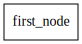

In [89]:
handle.dot_graph()

## Less simple

This example is too simple to show any real benefit. let's add resources.
We will now generate a `lab` which has a a database to which we save. 
This represents our entire lab, so in principle we only ever do this once and keep updating it as we go along. 



In [118]:

db_file='docs_cache/tutorial.db'
if os.path.exists(db_file):
  os.remove(db_file)
db = SqlAlchemyDB(db_file)
lab = LabResources(db)


We now add two example resources. one represents a lab device - an oscilloscope and the other is a measurement from some thing

note: if you run this cell twice you will get an error. You cannot add the same resource to your lab twice.

In [119]:
class my_thing:
    def __init__(self,name, val):
        self.name=name
        self.val=val

class my_scope:
    def __init__(self,name, ip):
        self.name=name
        self.ip=ip      
    
lab.register_resource("my_thing", my_thing,kwargs={'val':1,'name':'me'})
lab.register_resource("my_scope", my_scope,args=["gals scope"],experiment_kwargs={'ip':0})




KeyError: 'instrument my_thing already exist'

Now let's define the experiment. 

we begin with experiment resources which are the lab resources you will use in this specific experiment. 

you can also define temp resources which will not be saved with the lab (the scope you stole from the lab next door but have to give back)

In [120]:
def a(context: EntropyContext):
    x = 1
    y = 2
    print(context.get_resource("my_thing"))
    print(context.get_resource("my_scope"))
    print(x + y)
    return {"a_out": 10}

experiment_resources = ExperimentResources(db)
experiment_resources.import_lab_resource("my_thing")
experiment_resources.add_temp_resource("my_scope", 42)

node1 = PyNode("first_node", a,output_vars={'a_out'})
experiment2 = Graph(experiment_resources, {node1}, "run_a") #No resources used here
handle2 = experiment2.run()


# node2 = PyNode(experiment_resources, a, "running the exp")
# experiment = Graph(None, {node2}, "run_a") #No resources used here
# handle = experiment.run(db)
# exp_id = script_experiment_handle.id
# results = script_experiment_handle.results
# reader = ExperimentReader(exp_id, db)


2021-05-04 17:50:20,864 - entropy - INFO - Running node <PyNode> first_node
42
3
2021-05-04 17:50:20,918 - entropy - INFO - Finished entropy experiment execution successfully


In [113]:
handle2.results.get_results()

[ResultRecord(experiment_id=2, id=1, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=2, id=2, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10})]

In [123]:
experiment2.run().results.get_results()


2021-05-04 17:51:12,682 - entropy - INFO - Running node <PyNode> first_node
42
3
2021-05-04 17:51:12,733 - entropy - INFO - Finished entropy experiment execution successfully


[ResultRecord(experiment_id=9, id=15, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=9, id=16, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10})]

In [126]:
db.get_results()

[ResultRecord(experiment_id=2, id=1, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=2, id=2, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10}),
 ResultRecord(experiment_id=3, id=3, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=3, id=4, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10}),
 ResultRecord(experiment_id=4, id=5, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=4, id=6, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10}),
 ResultRecord(experiment_id=5, id=7, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=5, id=8, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10}),
 ResultRecord(experiment_id=6, id=9, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=6, id=10, label='